In [1]:
import pickle
import random
import os
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Dense, Input, Lambda, Flatten, Conv2D, MaxPooling2D, Cropping2D
from keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt
%matplotlib inline

def lambda_normalize(x):
    x -= K.mean(x, axis=1, keepdims=True)
    x /= K.std(x, axis=1, keepdims=True)
    return x

def lambda_rgb_to_grayscale(x):
    import tensorflow as tf
    return tf.image.rgb_to_grayscale(x)

def lambda_rgb_to_yuv(x):
    import tensorflow as tf
    return tf.image.rgb_to_yuv(x)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data

(41892, 160, 320, 3) (41892,)
(3695, 160, 320, 3) (3695,)


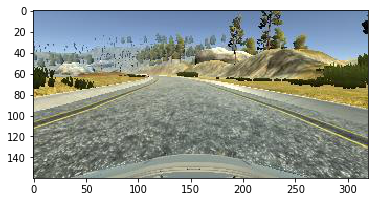

In [2]:
def read_log_data(paths, steering_correction=None, flip=False):
    images = []
    measurements = []
    
    for path in paths:
        log = pd.read_csv(path, header=None)
        log_images_center = log[0].tolist()
        log_images_left = log[1].tolist()
        log_images_right = log[2].tolist()
        log_steering = log[3].tolist()

        image_dir = '/'.join(path.split('/')[:-1]) + '/IMG/'

        for i in range(len(log_steering)):
            img_center = np.asarray(Image.open(image_dir + log_images_center[i].replace('\\', '/').split('/')[-1]))
            steering = log_steering[i]
            if img_center is None:
                continue

            images.append(img_center)
            measurements.append(steering)

            if flip:
                images.append(np.fliplr(img_center))
                measurements.append(-steering)

            if steering_correction is not None:
                img_left = np.asarray(Image.open(image_dir + log_images_left[i].replace('\\', '/').split('/')[-1]))
                img_right = np.asarray(Image.open(image_dir + log_images_right[i].replace('\\', '/').split('/')[-1]))
                if img_left is None or img_right is None:
                    continue

                images.extend([img_left, img_right])
                measurements.extend([steering+steering_correction, steering-steering_correction])

                if flip:
                    images.extend([np.fliplr(img_left), np.fliplr(img_right)])
                    measurements.extend([-steering-steering_correction, -steering+steering_correction])

    X = np.array(images)
    y = np.array(measurements)
    return (X, y)

# Dataset: d3
(X_train, y_train) = read_log_data(['data/driving_log_laps_1.csv'], steering_correction=0.1, flip=True)
(X_valid, y_valid) = read_log_data(['data/driving_log_laps_2.csv'])

# (X_train, y_train) = read_log_data(['data/driving_log_laps_1.csv', 'data/driving_log_laps_2.csv'], 
#                                    steering_correction=0.1, flip=True)
# (X_valid, y_valid) = (np.array([]), np.array([]))

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
plt.imshow(X_train[0])

# Model

In [34]:
# LeNet

inputs = Input(shape=(160,320,3))
x = Cropping2D(cropping=((60,30), (0,0)))(inputs)
x = Lambda(lambda x: x / 255.0, input_shape=(160,320,3))(x)
# model.add(Lambda(lambda_rgb_to_yuv))
x = Lambda(lambda x: 2 * (x - 0.5), input_shape=(160,320,3))(x)

x = Conv2D(6, (5, 5), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, (5, 5), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(120, activation='relu')(x)
x = Dense(84, activation='relu')(x)
y = Dense(1, activation='linear')(x)

model = Model(inputs=inputs, outputs=y)
model.compile(optimizer='Adam', loss='mse')

In [31]:
# # Xception

# from keras.applications.xception import Xception, preprocess_input

# inputs = Input(shape=(160,320,3))
# inputs = Cropping2D(cropping=((60,29), (0,0)))(inputs)
# inputs = Lambda(preprocess_input)(inputs)

# base_model = Xception(input_tensor=inputs, weights='imagenet', include_top=False, pooling='avg')
# x = base_model.output
# #x = Dense(1024, activation='relu')(x) # An extra fully connected layer, from Keras example - do we need it? 
# y = Dense(1, activation='linear')(x)
# model = Model(inputs=base_model.input, outputs=y)

# for layer in base_model.layers:
#     layer.trainable = False
    
# model.compile(optimizer='Adam', loss='mse')

In [9]:
# MobileNet

from keras.applications.mobilenet import MobileNet, preprocess_input

inputs = Input(shape=(160,320,3))
inputs = Cropping2D(cropping=((60,30), (0,0)))(inputs)
inputs = Lambda(preprocess_input)(inputs)

base_model = MobileNet(input_tensor=inputs, input_shape=(70,320,3), weights=None, include_top=False, pooling='avg')
x = base_model.output
y = Dense(1, activation='linear')(x)
model = Model(inputs=base_model.input, outputs=y)
    
model.compile(optimizer='Adam', loss='mse')

In [5]:
# # NVIDIA

# model = Sequential()
# model.add(Cropping2D(cropping=((60,30), (0,0)), input_shape=(160,320,3)))
# model.add(Lambda(lambda x: x / 255.0, input_shape=(160,320,3)))
# # model.add(Lambda(lambda_rgb_to_yuv))
# model.add(Lambda(lambda x: 2 * (x - 0.5), input_shape=(160,320,3)))

# model.add(Conv2D(24, (5, 5), strides=(2,2), activation='relu'))
# model.add(Conv2D(36, (5, 5), strides=(2,2), activation='relu'))
# model.add(Conv2D(48, (5, 5), strides=(2,2), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Flatten())
# model.add(Dense(100, activation='relu'))
# model.add(Dense(50, activation='relu'))
# model.add(Dense(10, activation='relu'))
# model.add(Dense(1, activation='linear'))

# model.compile(optimizer='Adam', loss='mse')

# Train

In [ ]:
name = 'd3_mobilenet'

history = model.fit(X_train, y_train, 
    epochs=10,
    batch_size=64, # TODO: 256?!
    validation_data=(X_valid, y_valid),
#     validation_split=0.2,
    shuffle=True,
    verbose=2)

model.save('models/' + name + '_10ep.h5')

Train on 41892 samples, validate on 3695 samples
Epoch 1/3
 - 299s - loss: 0.0257 - val_loss: 0.0086
Epoch 2/3
 - 294s - loss: 0.0039 - val_loss: 0.0102
Epoch 3/3
 - 294s - loss: 0.0025 - val_loss: 0.0136
Train on 41892 samples, validate on 3695 samples
Epoch 1/7
 - 294s - loss: 0.0019 - val_loss: 0.0044
Epoch 2/7
 - 294s - loss: 0.0016 - val_loss: 0.0064
Epoch 3/7
 - 294s - loss: 0.0014 - val_loss: 0.0061
Epoch 4/7
 - 294s - loss: 0.0012 - val_loss: 0.0027
Epoch 5/7
 - 293s - loss: 0.0011 - val_loss: 0.0085
Epoch 6/7
 - 294s - loss: 0.0013 - val_loss: 0.0015
Epoch 7/7
 - 294s - loss: 9.9142e-04 - val_loss: 0.0016
Train on 41892 samples, validate on 3695 samples
Epoch 1/10
 - 294s - loss: 0.0010 - val_loss: 0.0043
Epoch 2/10
 - 293s - loss: 7.1908e-04 - val_loss: 0.0030
Epoch 3/10


## Results

### Mobilenet

#### d3_mobilenet_10ep  (!!!!!!!!!!!)
Epoch 7/7
 - 294s - loss: 9.9142e-04 - val_loss: 0.0016
 
Drives the whole lap (9-15mph) !!!!

### LeNet

#### d3_lenet_rgb_20ep
Same as 10 ep
Epoch 10/10
 - 36s - loss: 4.0533e-04 - val_loss: 0.0011

#### d3_lenet_rgb_10ep
Passes dirt road! Falls into lake on right-turn (9-15mph). 
At 25mph oscillates, but reaches the same point.
At 30mph falls of the road.
Epoch 7/7
 - 41s - loss: 6.7343e-04 - val_loss: 0.0011

#### d3_lenet_rgb_3ep
Drives nicely at 9mph. Crashes into post at dirt road.
Epoch 3/3
 - 41s - loss: 0.0021 - val_loss: 0.0014

#### 3laps_sc01f_lenet_3ep
Epoch 3/3
 - 49s - loss: 8.1260e-04 - val_loss: 0.0014

#### 3laps_sc01f_lenet
Still exits to dirt road...
Epoch 10/10
 - 49s - loss: 3.9914e-04 - val_loss: 0.0013

#### sc01f_lenet_yuv
Worse than RGB - falls left just before the dirt road
Epoch 10/10
 - 43s - loss: 7.0162e-04 - val_loss: 0.0011

#### sc01f_lenet
Drives nicely at 9mph but exits to dirt road :)
Epoch 10/10
 - 42s - loss: 5.7387e-04 - val_loss: 0.0012

#### sc01_lenet_gray
Worse than RGB
Epoch 10/10
 - 20s - loss: 2.8323e-04 - val_loss: 0.0011

#### sc01_lenet_yuv2 
Crashes, worse than RGB
Epoch 10/10
 - 23s - loss: 1.7104e-04 - val_loss: 9.7790e-04
 
#### sc01_lenet2
Crashes on slight left to the lake. So sc01_lenet probably drives well by accident...

#### sc01_lenet
Reaches the sharp-turn-right at 9km/h
Epoch 10/10
 - 19s - loss: 5.1198e-04 - val_loss: (9.2570e-04)
 
#### sc02_lenet
Crashes earlier than sc01_lenet, and sways from side to side
Epoch 10/10
 - 19s - loss: 4.7747e-04 - val_loss: (0.0017)

#### lenet_rgb_crop30
Doesn't even drive staight
Epoch 10/10
 - 9s - loss: 2.6097e-04 - val_loss: 8.7463e-04

#### lenet_rgb_crop
Epoch 10/10
 - 11s - loss: 7.3926e-04 - val_loss: 7.7133e-04

#### lenet_gray_crop
Epoch 10/10
 - 11s - loss: 5.2351e-04 - val_loss: 7.2031e-04

#### lenet_gray
Epoch 10/10: 
 - 13s - loss: 3.8741e-04 - val_loss: 7.5241e-04

#### lenet_linear
Epoch 10/10: 
 - loss: 8.4305e-04 - val_loss: 0.0012

### Xception

#### d3_xception_3ep
Epoch 3/3
 - 237s - loss: 0.0111 - val_loss: 0.0312
 
#### d3_xception_10ep
Takes 300ms to predict - can't really drive. Probably would be bad anyway.
Epoch 7/7
 - 237s - loss: 0.0069 - val_loss: 0.0275

### NVIDIA

#### 3laps_sc01f_nvidia
Similar to LeNet - exits to dirt road
Epoch 10/10
 - 49s - loss: 1.1031e-04 - val_loss: 0.0014

#### sc01_nvidia_yuv
Epoch 10/10
 - 23s - loss: 2.3813e-04 - val_loss: 8.2031e-04

#### sc01_nvidia
Crashes earlier than LeNet
Epoch 10/10
 - 22s - loss: 1.0243e-04 - val_loss: 8.6053e-04

# Temp

In [58]:
layer_output_model = Model(inputs=model.input, outputs=model.layers[2].output)
layer_output = layer_output_model.predict(X_train[0:1])
x = layer_output[0]
print('Shape:', x.shape)
print('Min:', [np.min(x[:,:,i]) for i in range(x.shape[-1])])
print('Avg:', [np.mean(x[:,:,i]) for i in range(x.shape[-1])])
print('Max:', [np.max(x[:,:,i]) for i in range(x.shape[-1])])
print('Std:', [np.std(x[:,:,i]) for i in range(x.shape[-1])])
print(layer_output[0])

Shape: (70, 320, 3)
Min: [-1.0, -1.0, -1.0]
Avg: [-0.08651746, 0.09981832, 0.08554452]
Max: [0.9294119, 1.0, 1.0]
Std: [0.32808393, 0.3067266, 0.32662413]
[[[-0.8980392  -0.6078431  -0.67058825]
  [-0.81960785 -0.52941173 -0.5921568 ]
  [-1.         -0.75686276 -0.81960785]
  ...
  [-0.8117647  -0.45098037 -0.55294114]
  [-0.8039216  -0.44313723 -0.545098  ]
  [-0.8901961  -0.52941173 -0.6313726 ]]

 [[-0.8980392  -0.6078431  -0.67058825]
  [-0.85882354 -0.5686274  -0.6313726 ]
  [-0.96862745 -0.6784314  -0.7411765 ]
  ...
  [-0.8117647  -0.46666664 -0.5686274 ]
  [-0.8039216  -0.4588235  -0.5607843 ]
  [-0.8901961  -0.545098   -0.64705884]]

 [[-1.         -0.84313726 -0.8901961 ]
  [-0.9529412  -0.654902   -0.7019608 ]
  [-0.8901961  -0.5921568  -0.6392157 ]
  ...
  [-0.8509804  -0.5058823  -0.6078431 ]
  [-0.827451   -0.4823529  -0.5843137 ]
  [-0.9137255  -0.5686274  -0.67058825]]

 ...

 [[-0.30196077 -0.2156862  -0.23921561]
  [-0.01960778  0.06666672  0.04313731]
  [ 0.19215691 

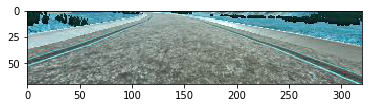

In [73]:
plt.imshow(layer_output[0].squeeze() / 255)